In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Brain_MRI

/content/drive/My Drive/Brain_MRI


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
mri_df = pd.read_csv("data_mask.csv")

In [ ]:
mri_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
mri_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
mri_df["mask"].value_counts() # Dataset is not balanced as there are 2556 healthy patients and 1373 sick patients data

0    2556
1    1373
Name: mask, dtype: int64

## PERFORMING DATA VISUALISZATION

In [ ]:
mri_df["mask"].value_counts().index

Int64Index([0, 1], dtype='int64')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = mri_df["mask"].value_counts().index, y = mri_df["mask"].value_counts())])
fig.update_traces(marker_color = 'rgb(0, 200, 200)', marker_line_color = 'rgb(255, 0 , 0)', marker_line_width = 3, opacity = 0.6)
fig.show()

In [ ]:
mri_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
mri_df.image_path[0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

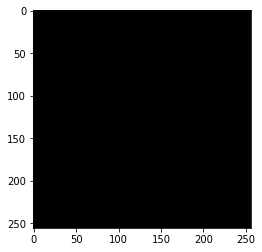

In [ ]:
plt.imshow(cv2.imread(mri_df["mask_path"][656]))

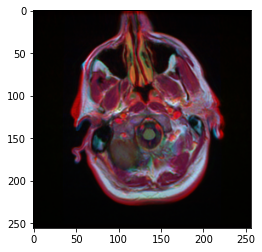

In [ ]:
plt.imshow(cv2.imread(mri_df.image_path[656]))

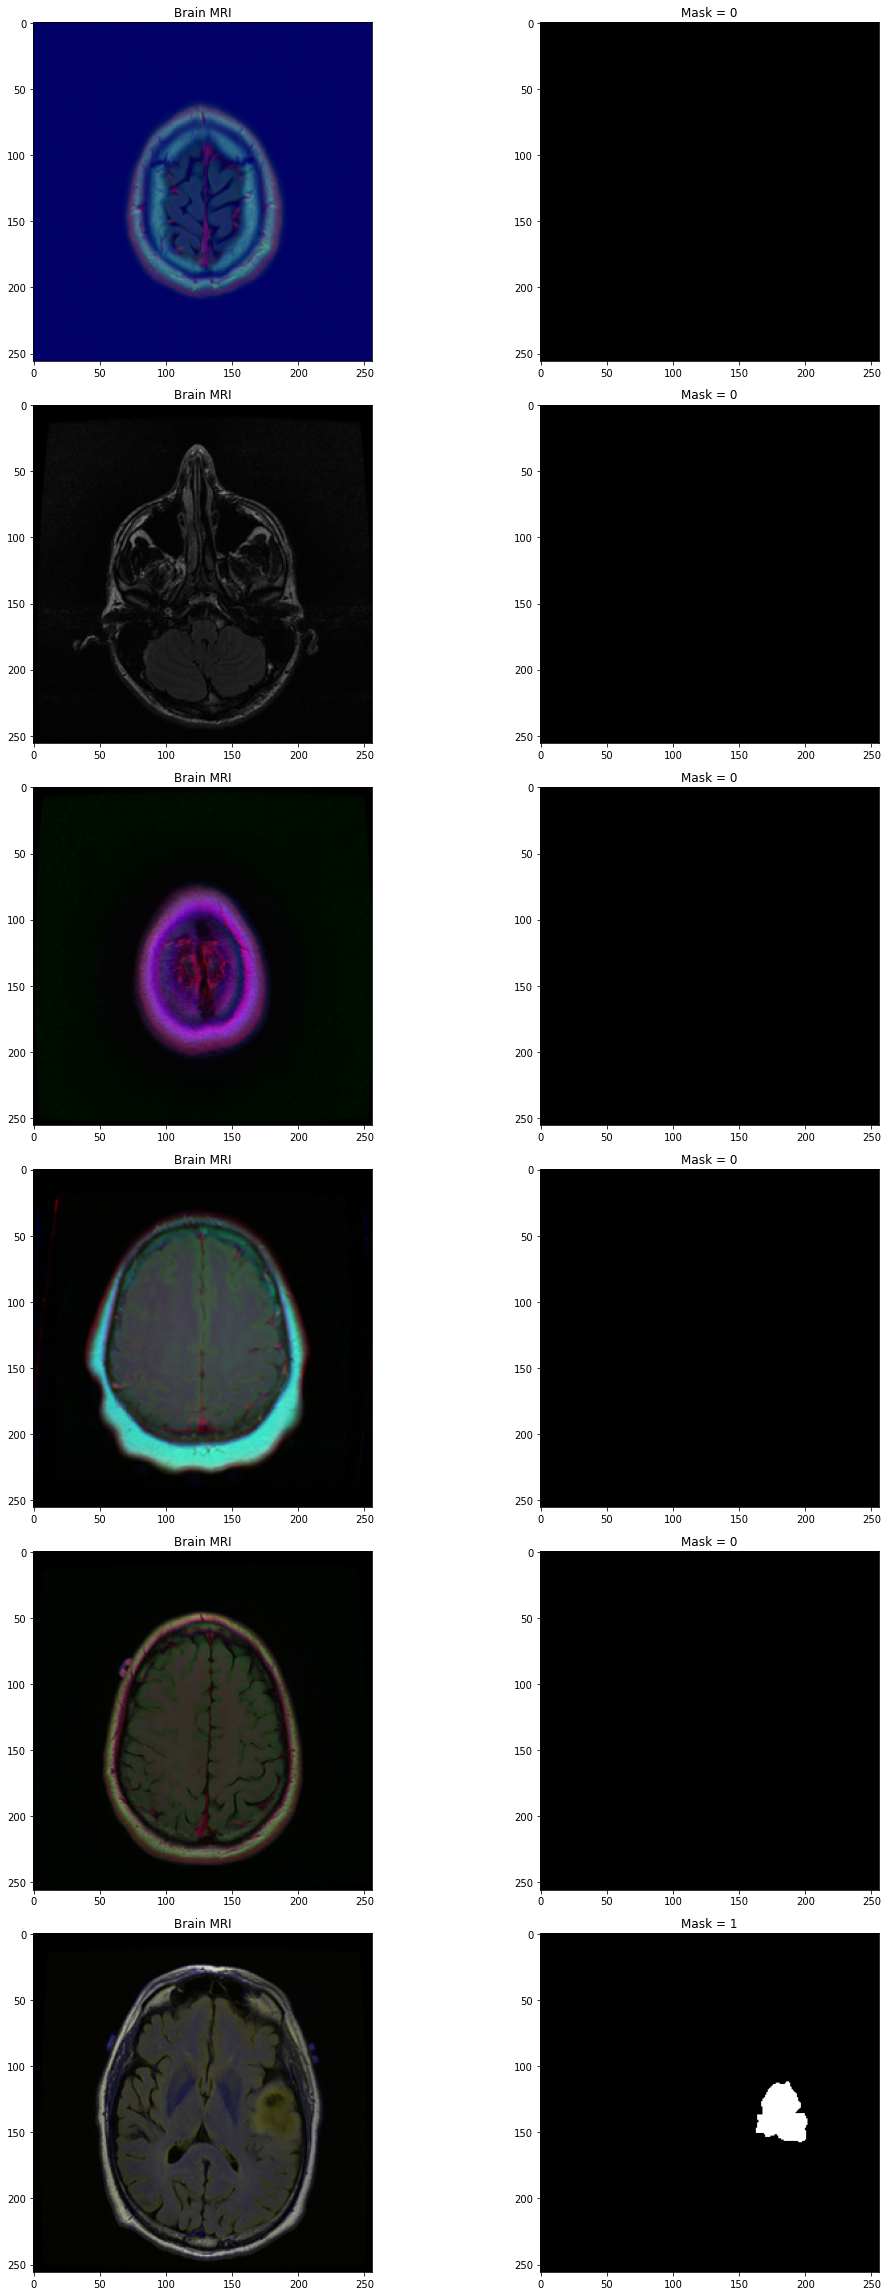

In [ ]:
# Visualizing the images with their mask and if they have tumor or not
import random
fig, axes = plt.subplots(6, 2, figsize = (16, 32))
for i in range(6):
  rand_index = random.randint(0,len(mri_df))
  axes[i][0].title.set_text("Brain MRI")
  axes[i][0].imshow(cv2.imread(mri_df.image_path[rand_index]))
  axes[i][1].title.set_text("Mask = " + str(mri_df['mask'][rand_index]))
  axes[i][1].imshow(cv2.imread(mri_df.mask_path[rand_index]))

fig.tight_layout()

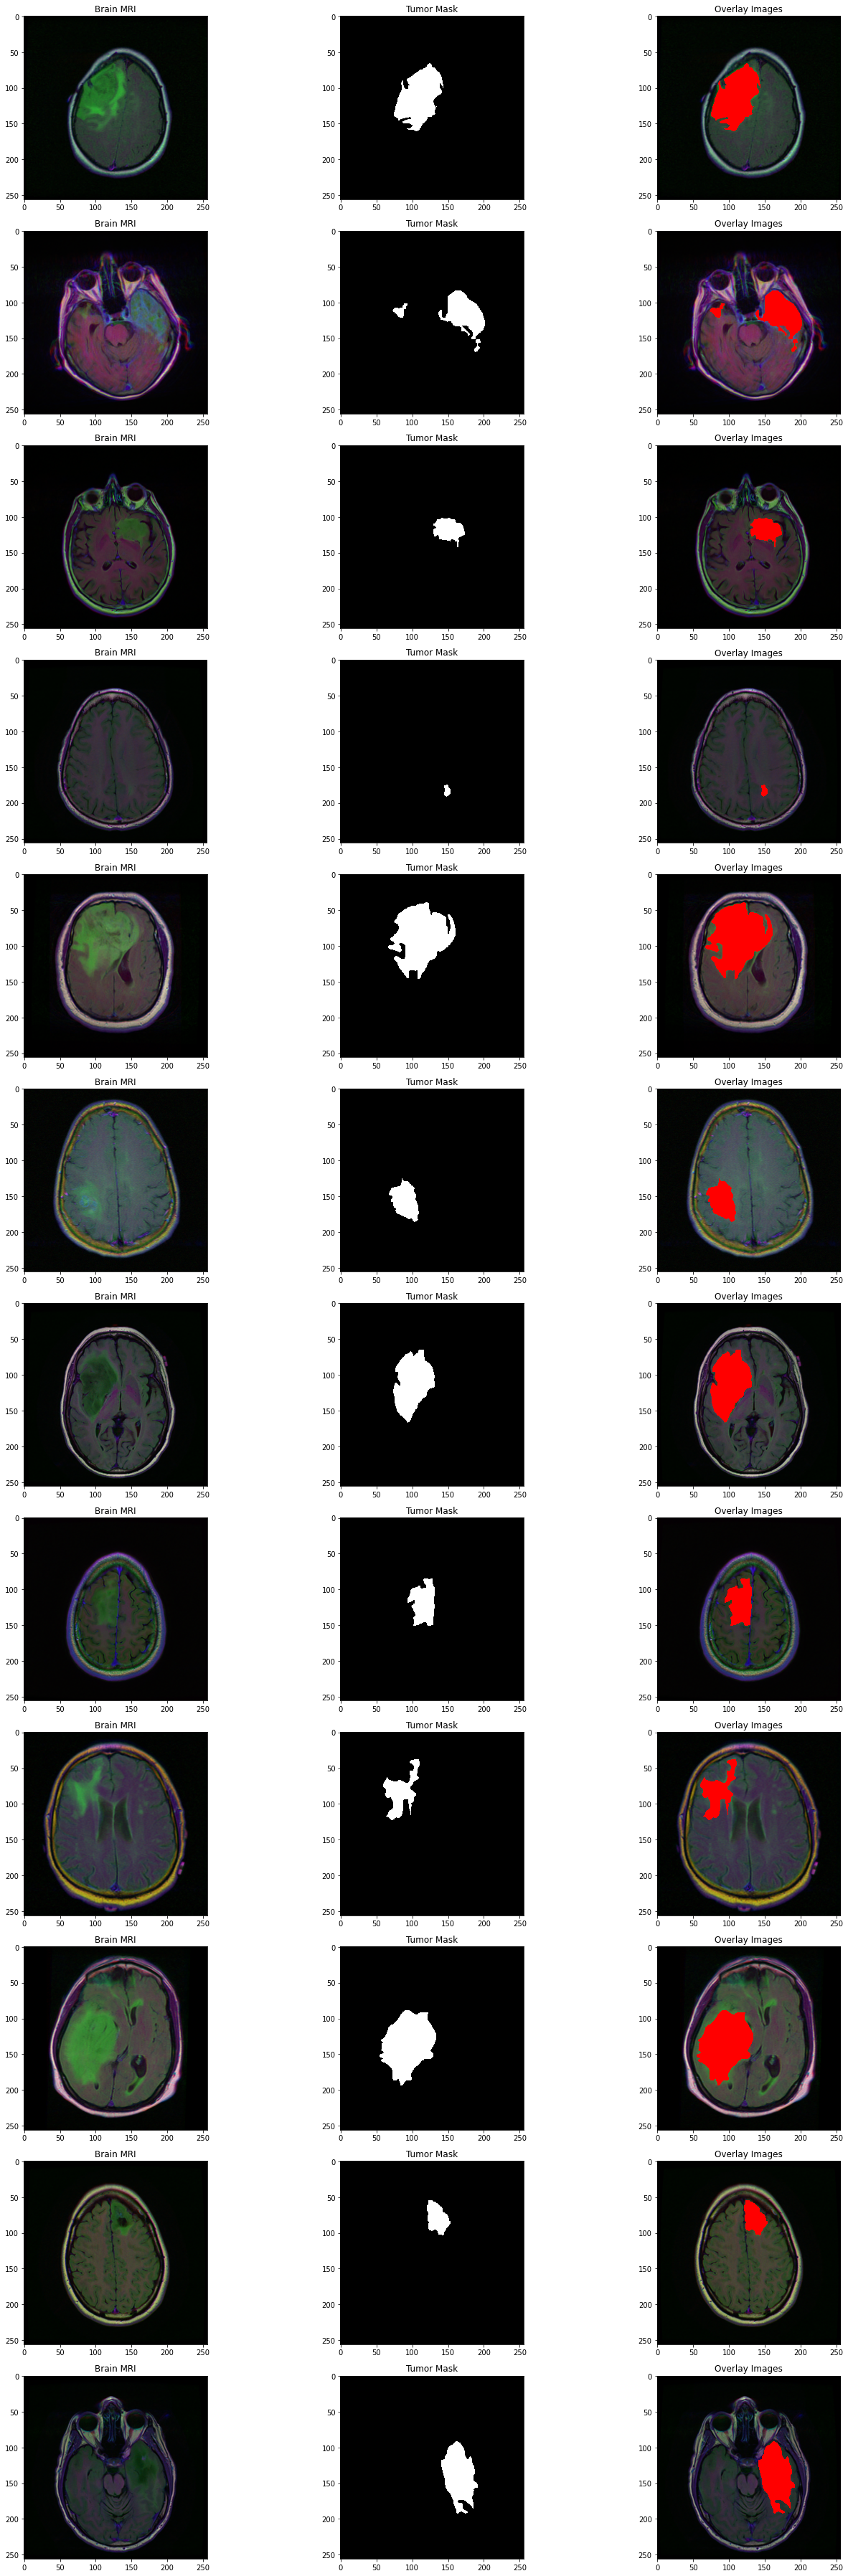

In [ ]:
# Plotting the images of only sick patients
fig, axes = plt.subplots(12, 3, figsize = (20, 50))

plot = 0

while plot < 12:
  rand_index = random.randint(0, len(mri_df))
  if int(mri_df['mask'][rand_index]) != 1:
    continue
  # First Column plotting the image
  axes[plot][0].title.set_text("Brain MRI")
  img = io.imread(mri_df.image_path[rand_index])
  axes[plot][0].imshow(img)

  # Second columns plotting the mask
  axes[plot][1].title.set_text("Tumor Mask")
  mask = io.imread(mri_df.mask_path[rand_index])
  axes[plot][1].imshow(mask, cmap = 'gray')

  # Third column plotting the images on top of other image
  axes[plot][2].title.set_text("Overlay Images")
  img[mask == 255] = (255, 0, 0)
  axes[plot][2].imshow(img)
  plot += 1

fig.tight_layout()



## Building a classifier to detect tumors

In [ ]:
# Dropping pateints id as it is not needed
train_df = mri_df.drop(["patient_id"], axis = 1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [ ]:
# Have to turn all the mask columns values into string or It will get the type error
train_df['mask'] = train_df['mask'].apply(lambda x: str(x))
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, test_size = 0.15)

In [ ]:
# Image pre processing
from keras_preprocessing.image import ImageDataGenerator

# Creating the data generator which normalizes the images and also create 15% validation split
dataGen = ImageDataGenerator(rescale = 1./255. , validation_split = 0.15)

In [ ]:
trainGen = dataGen.flow_from_dataframe(dataframe = train, 
                                       directory = './', 
                                       x_col = 'image_path',
                                       y_col = 'mask',
                                       subset = 'training', 
                                       batch_size = 16, 
                                       shuffle = True,
                                       class_mode = "categorical",
                                       target_size = (256, 256))


validationGen = dataGen.flow_from_dataframe(dataframe = train,
                                            directory = './', 
                                            x_col = 'image_path',
                                            y_col = 'mask',
                                        subset = 'validation', 
                                        batch_size = 16, 
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (256, 256))

testGen = ImageDataGenerator(rescale = 1./255.)

testDataGen = testGen.flow_from_dataframe(dataframe = test,
                                            directory = './', 
                                            x_col = 'image_path',
                                            y_col = 'mask',
                                        batch_size = 16, 
                                        shuffle = False,
                                        class_mode = "categorical",
                                        target_size = (256, 256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Applying transfer learning...
# Getting the base model ResNet50 base model

baseModel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Freezing the model weights as I don't want to change them just fine tune them
# for layer in baseModel.layers:
#   layers.trainable = False

In [ ]:
# Now combining the downloaded model with new classification head 

classificationModel = baseModel.output
classificationModel = AveragePooling2D(pool_size = (4, 4))(classificationModel)
classificationModel = Flatten(name = 'flatten')(classificationModel)
classificationModel = Dense(256, activation = 'relu')(classificationModel)
classificationModel = Dropout(0.5)(classificationModel)
classificationModel = Dense(256, activation = 'relu')(classificationModel)
classificationModel = Dropout(0.3)(classificationModel)
classificationModel = Dense(2, activation = 'softmax')(classificationModel)


model = Model(inputs = baseModel.input, outputs = classificationModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Compiling the model

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Defining early stopping if the validation loss is not decreasing after certain epochs also called patience
earlyStop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

# Checkpointer saving the model with the least validation loss
checkpoint = ModelCheckpoint(filepath = 'ClassifierModelResNet50.hdf5', verbose = 1, save_best_only = True)


In [ ]:
# history = model.fit(trainGen, steps_per_epoch = trainGen.n // 16, epochs = 1000, validation_data = validationGen, 
#                     validation_steps = validationGen.n // 16, callbacks = [checkpoint, earlyStop])

In [ ]:
# Saving the Model Architecture for future Use
json_model = model.to_json()
with open("ResNet_Classifier_Model.json", "w") as f:
  f.write(json_model)


## Accessing Trained Model Performance

In [ ]:
# Loading the model
with open("ResNet_Classifier_Model.json", "r") as f:
  json_SavedModel = f.read()

model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights("ClassifierModelResNet50.hdf5")
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
predictions = model.predict(testDataGen, steps = testDataGen.n // 16, verbose = 1)

36/36 [==============================] - 385s 11s/step


In [ ]:
predictions.shape

(576, 2)

In [ ]:
predictions

array([[1.0000000e+00, 5.2229160e-10],
       [1.0000000e+00, 1.1912814e-08],
       [9.9999380e-01, 6.1596866e-06],
       ...,
       [9.9981779e-01, 1.8227709e-04],
       [1.0000000e+00, 1.1401131e-28],
       [9.9999940e-01, 6.4868829e-07]], dtype=float32)

In [ ]:
predict = []

for i in predictions:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0',
       '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1',
       '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0',
       '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1',
       '0', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1',
       '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0

In [ ]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# plotting the confusion matrix
from sklearn.metrics import accuracy_score ,confusion_matrix

accuracy = accuracy_score(original, predict)
accuracy


0.9878472222222222

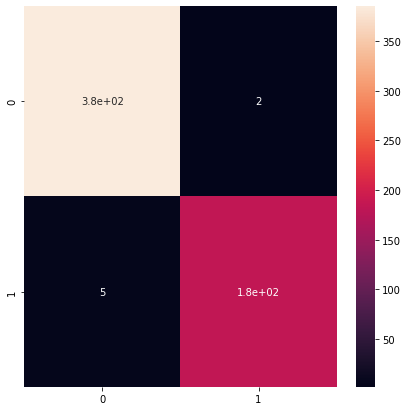

In [ ]:
cm = confusion_matrix(original, predict)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(original, predict, labels = [0, 1])
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       387
           1       0.99      0.97      0.98       189

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.98      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## Building the Segmentation Model to localize the tumor

In [ ]:
# Getting the df of only sick patients
mask_mri = mri_df[mri_df['mask'] == 1]
mask_mri.shape

(1373, 4)

In [ ]:
# Splitting the data into training, testing and splitting
train_X, val = train_test_split(mask_mri, test_size = 0.15)
test_X, val = train_test_split(val, test_size = 0.5)

In [ ]:
# Creating the separate list for the ImageId and classId to pass into the generator

trainId = list(train_X.image_path)
trainMasks = list(train_X.mask_path)

valId = list(val.image_path)
valMasks = list(val.mask_path)

In [ ]:
# Utilities contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# Create Image generators

trainingGen = DataGenerator(trainId, trainMasks)
validationGen = DataGenerator(valId, valMasks)

In [ ]:
# Creating the Res Block

def resBlock(X, f):

  # Make a copy of the input to attach it later so that gradient don't vanish
  X_copy = X

  # Main Path
  X = Conv2D(f, kernel_size = (1, 1), strides = (1, 1), kernel_initializer= 'he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer= 'he_normal')(X)
  X = BatchNormalization()(X)

  # Short Path
  X_copy = Conv2D(f, kernel_size = (1, 1), strides = (1, 1), kernel_initializer= 'he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the main path and short path together
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# Function to upscale and concatenate the values passed
from tensorflow.keras.layers import Concatenate as ct

def upsample_Add(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = ct()([x, skip])

  return merge

In [ ]:
# Building ResUnet Network
input_shape = (256, 256, 3)

# Input Tensor shape
x_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer= 'he_normal')(x_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_layer_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resBlock(pool_layer_1, 32)
pool_layer_2 = MaxPool2D(pool_size = (2, 2))(conv2_in)

# Stage 3
conv3_in = resBlock(pool_layer_2, 64)
pool_layer_3 = MaxPool2D(pool_size = (2, 2))(conv3_in)

# Stage 4
conv4_in = resBlock(pool_layer_3, 128)
pool_layer_4 = MaxPool2D(pool_size = (2, 2))(conv4_in)

# Stage 5 Bottle Neck
conv5_in = resBlock(pool_layer_4, 256)

# UpScale Stage 1
up_1 = upsample_Add(conv5_in, conv4_in)
up_1 = resBlock(up_1, 128)

# UpScale Stage 2
up_2 = upsample_Add(up_1, conv3_in)
up_2 = resBlock(up_2, 64)

# UpScale Stage 3
up_3 = upsample_Add(up_2, conv2_in)
up_3 = resBlock(up_3, 32)

# UpScale Stage 4
up_4 = upsample_Add(up_3, conv1_in)
up_4 = resBlock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = 'same', activation = 'sigmoid')(up_4)
segmentation_model = Model(inputs = x_input, outputs = output)
                                            

In [ ]:
segmentation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

## Training the segmentation RESUNET model to localize tumors

In [ ]:
# To Train the RESUNET model we have to use the special loss function that is tversky loss
from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon= 0.1)
segmentation_model.compile( optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
earlyStop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

checkPoint = ModelCheckpoint(filepath = 'RESUNET-weights.hdf5', verbose = 1, save_best_only = True)

In [ ]:
# history = segmentation_model.fit(trainingGen, epochs = 1000, validation_data = validationGen, callbacks = [earlyStop, checkPoint])

In [ ]:
# Saving the model
json_Model = segmentation_model.to_json()

with open("ResUNET-Model.json", "w") as f:
  f.write(json_Model)

## Accessing the Model Performance

In [ ]:
with open("ResUNET-Model.json", "r") as f:
  saved_Model = f.read()

segModel = tf.keras.models.model_from_json(saved_Model)
segModel.load_weights("RESUNET-weights.hdf5")
segModel.compile( optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# To find the accuracy we need the predictions from utilities file
from utilities import prediction

# Making predictions
image_id, mask, has_mask = prediction(test, model, segModel)

1/1 [==============================] - 0s 20ms/step


In [ ]:
# creating the dataframe for the result

df_pred = pd.DataFrame({'image_path' : image_id, 'predicted_mask' : mask, 'has_mask' : has_mask})
df_pred.head()

image_path  \
0  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6.tif   
1  TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7.tif   
2  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46...   
3  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12...   
4  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29...   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2                                            No mask         0  
3  [[[[1.6204551e-06], [5.2405437e-07], [3.933135...         1  
4  [[[[1.1307137e-06], [1.9887983e-07], [1.102928...         1

In [ ]:
test.head()

image_path  \
571   TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6.tif   
711   TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7.tif   
3591  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46...   
1297  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12...   
2868  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29...   

                                              mask_path mask  
571   TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6_...    0  
711   TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7_...    0  
3591  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46...    0  
1297  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12...    1  
2868  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29...    1

In [ ]:
# Merging the testing and predicted dataframe
df_pred = test.merge(right =df_pred, on = 'image_path')
df_pred.columns

Index(['image_path', 'mask_path', 'mask', 'predicted_mask', 'has_mask'], dtype='object')

In [ ]:
df_pred.head()

image_path  \
0  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6.tif   
1  TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7.tif   
2  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46...   
3  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12...   
4  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29...   

                                           mask_path mask  \
0  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_6_...    0   
1  TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7_...    0   
2  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_46...    0   
3  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_12...    1   
4  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29...    1   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2                                            No mask         0  
3  [[[[1.6204551e-06], [5.2405437e-07], [3.933135...         1  
4  [[[[1.1307137e-06], [1.9887983e-07], [1.102928...         1

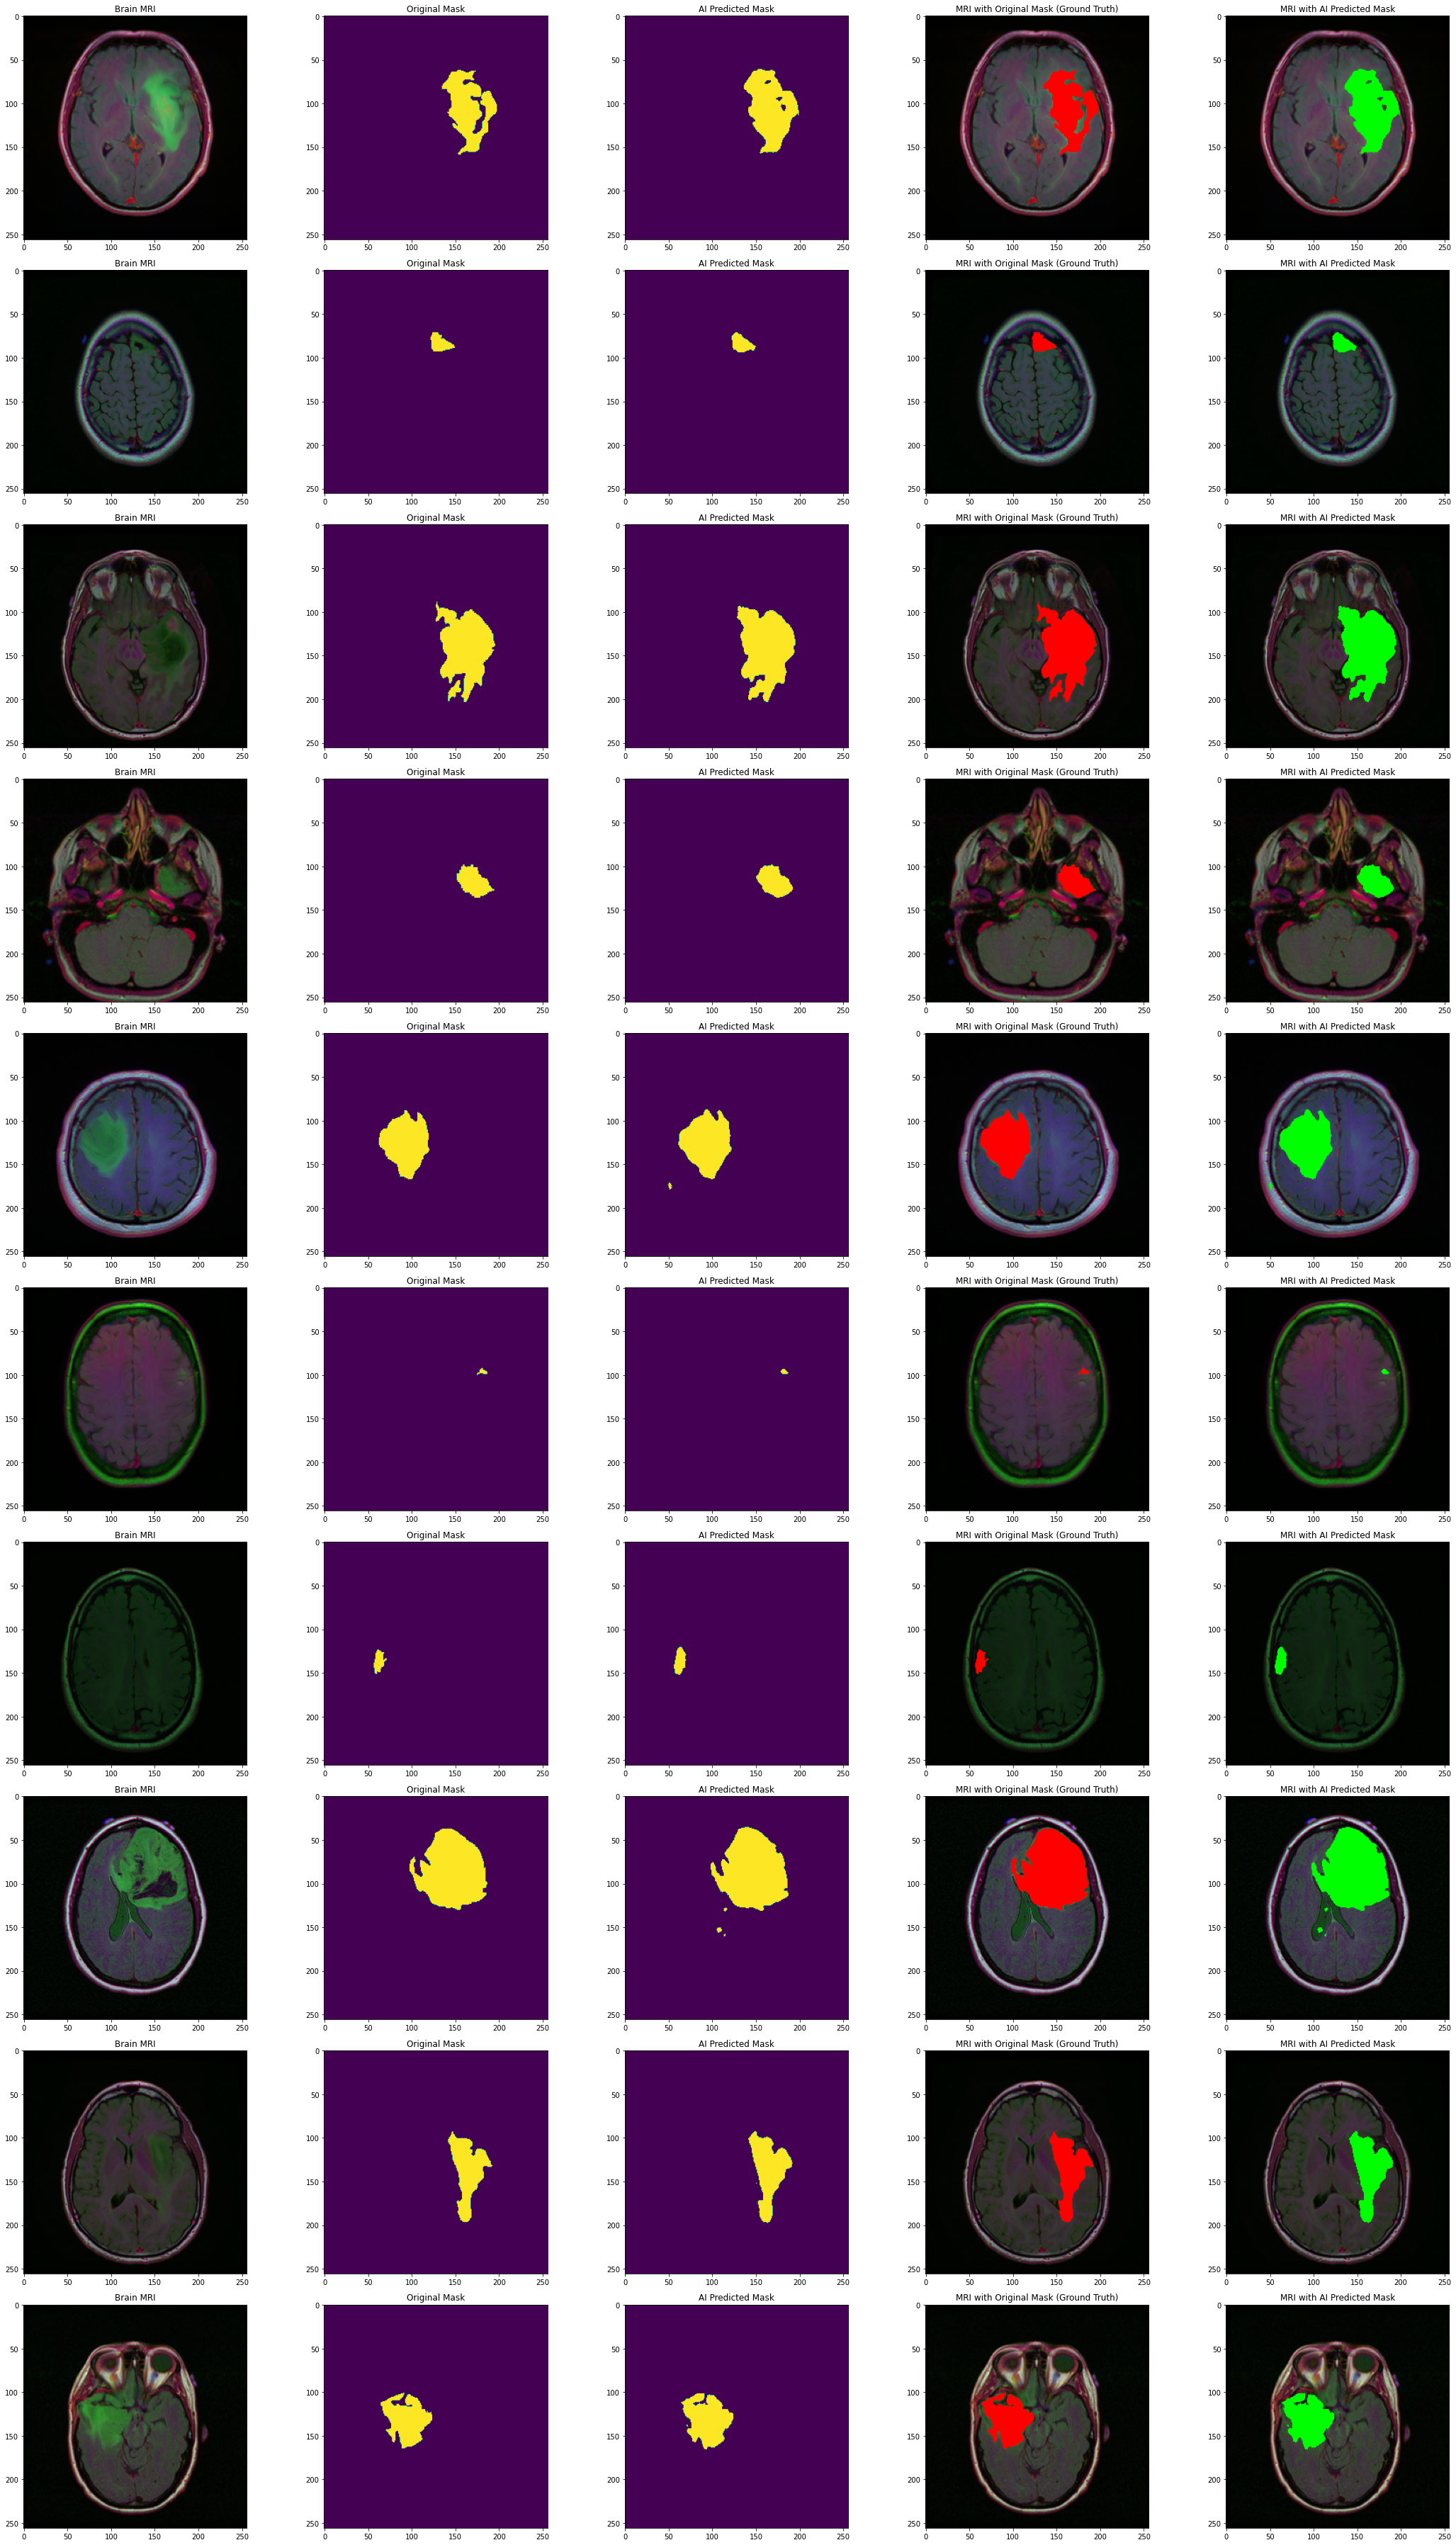

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()